<a href="https://colab.research.google.com/github/AyaHeshaam/Stegasus/blob/main/GBRAS_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GBRAS-Net with different Database Partition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers
from keras import regularizers
import tensorflow as tf
import cv2
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import to_categorical

## 30 SRM filters for preprocessing and the activation function

In [ ]:

################################################## 30 SRM FILTERS
srm_weights = np.load('/content/drive/MyDrive/SRM_Kernels (2).npy')
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


## TPU

In [ ]:
#https://www.tensorflow.org/guide/tpu
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/tpu.ipynb
#https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=_pQCOmISAQBu
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0
Running on TPU  ['10.20.152.114:8470']


## GBRAS-Net architecture

In [ ]:
def GBRAS_Net():
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers)
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip1)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 6
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 7
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 8
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers3)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 9
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers)
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip2 =   tf.keras.layers.Add()([layers3, layers4])
    #Layer 10
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip2)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 13
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 15
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 16
    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 17
    layers = tf.keras.layers.Conv2D(2, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 18
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print ("Model GBRAS-Net Generated")
    return model

## Defining different functions to work with the architecture

In [ ]:

def Final_Results_Valid(PATH_trained_models):
    global AccValid
    global LossValid
    AccValid = []
    LossValid = []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = GBRAS_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_valid, y_valid, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccValid  = accuracy
            BandLossValid = loss
            AccValid.append(BandAccValid)
            LossValid.append(BandLossValid)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def Final_Results_Train(PATH_trained_models):
    global AccTrain
    global LossTrain
    AccTrain = []
    LossTrain = []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = GBRAS_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_train, y_train, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccTrain  = accuracy
            BandLossTrain = loss
            AccTrain.append(BandAccTrain)
            LossTrain.append(BandLossTrain)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = GBRAS_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_test, y_test, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)
            LossTest.append(BandLossTest)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def graphics(AccTest, AccTrain, AccValid, LossTest, LossTrain, LossValid, model_name, path_img_base):
    if not os.path.exists(path_img_base+"/"+model_name):
       os.makedirs(path_img_base+"/"+model_name)

    with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
        model = GBRAS_Net()

    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(AccTrain)],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(AccValid)],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_GBRAS_Net_'+model_name+'.eps', format='eps')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_GBRAS_Net_'+model_name+'.svg', format='svg')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_GBRAS_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(LossTrain)],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(LossValid)],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_GBRAS_Net_'+model_name+'.eps', format='eps')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_GBRAS_Net_'+model_name+'.svg', format='svg')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_GBRAS_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

In [ ]:
def top_models(AccTest,AccTrain,AccValid):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Test Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    numbers=AccTrain
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Train Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    numbers=AccValid
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, epoch:{}\n".format(value, index+1))

In [ ]:
def trainTPU(path_model, epochs, model_Name):
    global model_name
    start_time = tm.time()
    model_name = model_Name
    path_log_base = path_model+'/'+model_Name
    if not os.path.exists(path_log_base):
        os.makedirs(path_log_base)

    with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
         model = GBRAS_Net()

    epoch_ = 1
    for epoch in range(epochs):
        epoch=epoch+1
        print("epoch ",epoch)
        model.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=128*2, epochs=epoch_, verbose=1)
        model.save_weights(path_model+'/'+model_name+'/'+str(epoch).zfill(4)+'.hdf5', overwrite=True)

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)

# Database Partition

Choose any of the Database partition and train model.

## Training image pairs(4000), Validation image pairs(1000), and Test image pairs(5000)

In [ ]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01'
paths = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis
print("Xc_ dimensions:", Xc_.shape)
print("Xs_ dimensions:", Xs_.shape)
X_ = numpy.vstack((Xc_, Xs_))
print("X_ dimensions:", X_.shape)


print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Xc_ dimensions: (10000, 1, 256, 256)
Xs_ dimensions: (10000, 1, 256, 256)
X_ dimensions: (20000, 1, 256, 256)
Total image data and labels (20000, 1, 256, 256) (20000, 2)
(8000, 1, 256, 256)
(8000, 2)
(2000, 1, 256, 256)
(2000, 2)
(10000, 1, 256, 256)
(10000, 2)


## Training image pairs(2500), Validation image pairs(2500), and Test image pairs(5000)

In [ ]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01'
paths = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:2500],X_[10000:12500]],axis=0)
X_valid = np.concatenate([X_[2500:5000],X_[12500:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:2500],Xt_[10000:12500]],axis=0)
y_valid = np.concatenate([Xt_[2500:5000],Xt_[12500:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(5000, 256, 256, 1)
(5000, 2)
(5000, 256, 256, 1)
(5000, 2)
(10000, 256, 256, 1)
(10000, 2)


## Training image pairs(4000), Validation image pairs(3000), and Test image pairs(3000)

In [ ]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01'
paths = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:7000],X_[14000:17000]],axis=0)
X_test  = np.concatenate([X_[7000:10000],X_[17000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:7000],Xt_[14000:17000]],axis=0)
y_test  = np.concatenate([Xt_[7000:10000],Xt_[17000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(6000, 256, 256, 1)
(6000, 2)
(6000, 256, 256, 1)
(6000, 2)


## Training image pairs(8000), Validation image pairs(1000), and Test image pairs(1000)

In [ ]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01'
paths = '/content/drive/MyDrive/GBRAS-Net/BOSSbase-1.01/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:8000],X_[10000:18000]],axis=0)
X_valid = np.concatenate([X_[8000:9000],X_[18000:19000]],axis=0)
X_test  = np.concatenate([X_[9000:10000],X_[19000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:8000],Xt_[10000:18000]],axis=0)
y_valid = np.concatenate([Xt_[8000:9000],Xt_[18000:19000]],axis=0)
y_test  = np.concatenate([Xt_[9000:10000],Xt_[19000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(16000, 256, 256, 1)
(16000, 2)
(2000, 256, 256, 1)
(2000, 2)
(2000, 256, 256, 1)
(2000, 2)


## CNN name and algorithm

## Training

In [ ]:
path_model = "/content/drive/MyDrive/GradP/WOW/logs4"
path_img_base = "./Image/WOW/images"

model_Name = "GBRAS_Net..."

trainTPU(path_model=path_model, epochs=150, model_Name = "GBRAS_Net...")

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model GBRAS-Net Generated
epoch  1
63/63 [==============================] - 169s 2s/step - loss: 0.6899 - accuracy: 0.5254 - val_loss: 0.6844 - val_accuracy: 0.5530
epoch  2
63/63 [==============================] - 89s 1s/step - loss: 0.6533 - accuracy: 0.6100 - val_loss: 0.6773 - val_accuracy: 0.5375
epoch  3
63/63 [==============================] - 89s 1s/step - loss: 0.6255 - accuracy: 0.6477 - val_loss: 0.6260 - val_accuracy: 0.6320
epoch  4
63/63 [==============================] - 89s 1s/step - loss: 0.6082 - accuracy: 0.6652 - val_loss: 0.6396 - val_accuracy: 0.6100
epoch  5
63/63 [==============================] - 89s 1s/step - loss: 0.5967 - accuracy: 0.6803 - val_loss: 0.6192 - val_accuracy: 0.6505
epoch  6
63/63 [==============================] - 89s 1s/step - loss: 0.5844 - accuracy: 0.6892 - val_loss: 0.6069 - val_accuracy: 0.6470
epoch  7
63/63 [==============================] - 89s 1s/step - loss: 0.5731 - accuracy: 0.6977 - val_loss: 0.5901 - val_accuracy: 0.6650
epoch  

## Test

In [ ]:
Final_Results_Test(path_model+"/"+model_Name)

0001.hdf5
Model GBRAS-Net Generated
Loss=0.6731 y Accuracy=0.5800

0002.hdf5
Model GBRAS-Net Generated
Loss=0.6517 y Accuracy=0.5620

0003.hdf5
Model GBRAS-Net Generated
Loss=0.5765 y Accuracy=0.6975

0004.hdf5
Model GBRAS-Net Generated
Loss=0.5910 y Accuracy=0.6580

0005.hdf5
Model GBRAS-Net Generated
Loss=0.5621 y Accuracy=0.6910

0006.hdf5
Model GBRAS-Net Generated
Loss=0.5387 y Accuracy=0.7210

0007.hdf5
Model GBRAS-Net Generated
Loss=0.5313 y Accuracy=0.7170

0008.hdf5
Model GBRAS-Net Generated
Loss=0.5605 y Accuracy=0.6900

0009.hdf5
Model GBRAS-Net Generated
Loss=0.5237 y Accuracy=0.7430

0010.hdf5
Model GBRAS-Net Generated
Loss=0.4931 y Accuracy=0.7595

0011.hdf5
Model GBRAS-Net Generated
Loss=0.4882 y Accuracy=0.7785

0012.hdf5
Model GBRAS-Net Generated
Loss=0.4954 y Accuracy=0.7750

0013.hdf5
Model GBRAS-Net Generated
Loss=0.4652 y Accuracy=0.7965

0014.hdf5
Model GBRAS-Net Generated
Loss=0.4730 y Accuracy=0.7710

0015.hdf5
Model GBRAS-Net Generated
Loss=0.4484 y Accuracy=0.7

## Validation

In [ ]:
Final_Results_Valid(path_model+"/"+model_Name)

0001.hdf5
Model GBRAS-Net Generated
Loss=0.6819 y Accuracy=0.5535

0002.hdf5
Model GBRAS-Net Generated
Loss=0.6720 y Accuracy=0.5450

0003.hdf5
Model GBRAS-Net Generated
Loss=0.6249 y Accuracy=0.6380

0004.hdf5
Model GBRAS-Net Generated
Loss=0.6341 y Accuracy=0.6245

0005.hdf5
Model GBRAS-Net Generated
Loss=0.6164 y Accuracy=0.6465

0006.hdf5
Model GBRAS-Net Generated
Loss=0.6044 y Accuracy=0.6500

0007.hdf5
Model GBRAS-Net Generated
Loss=0.5847 y Accuracy=0.6700

0008.hdf5
Model GBRAS-Net Generated
Loss=0.5999 y Accuracy=0.6610

0009.hdf5
Model GBRAS-Net Generated
Loss=0.5760 y Accuracy=0.6800

0010.hdf5
Model GBRAS-Net Generated
Loss=0.5598 y Accuracy=0.7025

0011.hdf5
Model GBRAS-Net Generated
Loss=0.5606 y Accuracy=0.7080

0012.hdf5
Model GBRAS-Net Generated
Loss=0.5612 y Accuracy=0.7180

0013.hdf5
Model GBRAS-Net Generated
Loss=0.5393 y Accuracy=0.7185

0014.hdf5
Model GBRAS-Net Generated
Loss=0.5500 y Accuracy=0.6950

0015.hdf5
Model GBRAS-Net Generated
Loss=0.5217 y Accuracy=0.7

## Train

In [ ]:
Final_Results_Train(path_model+"/"+model_Name)

0001.hdf5
Model GBRAS-Net Generated
Loss=0.6866 y Accuracy=0.5422

0002.hdf5
Model GBRAS-Net Generated
Loss=0.6663 y Accuracy=0.5656

0003.hdf5
Model GBRAS-Net Generated
Loss=0.6071 y Accuracy=0.6603

0004.hdf5
Model GBRAS-Net Generated
Loss=0.6224 y Accuracy=0.6208

0005.hdf5
Model GBRAS-Net Generated
Loss=0.6026 y Accuracy=0.6551

0006.hdf5
Model GBRAS-Net Generated
Loss=0.5805 y Accuracy=0.6777

0007.hdf5
Model GBRAS-Net Generated
Loss=0.5610 y Accuracy=0.7041

0008.hdf5
Model GBRAS-Net Generated
Loss=0.5973 y Accuracy=0.6541

0009.hdf5
Model GBRAS-Net Generated
Loss=0.5473 y Accuracy=0.7327

0010.hdf5
Model GBRAS-Net Generated
Loss=0.5330 y Accuracy=0.7391

0011.hdf5
Model GBRAS-Net Generated
Loss=0.5309 y Accuracy=0.7572

0012.hdf5
Model GBRAS-Net Generated
Loss=0.5305 y Accuracy=0.7647

0013.hdf5
Model GBRAS-Net Generated
Loss=0.5071 y Accuracy=0.7667

0014.hdf5
Model GBRAS-Net Generated
Loss=0.5190 y Accuracy=0.7268

0015.hdf5
Model GBRAS-Net Generated
Loss=0.4904 y Accuracy=0.7

## Training, validation and testing graph

Model GBRAS-Net Generated


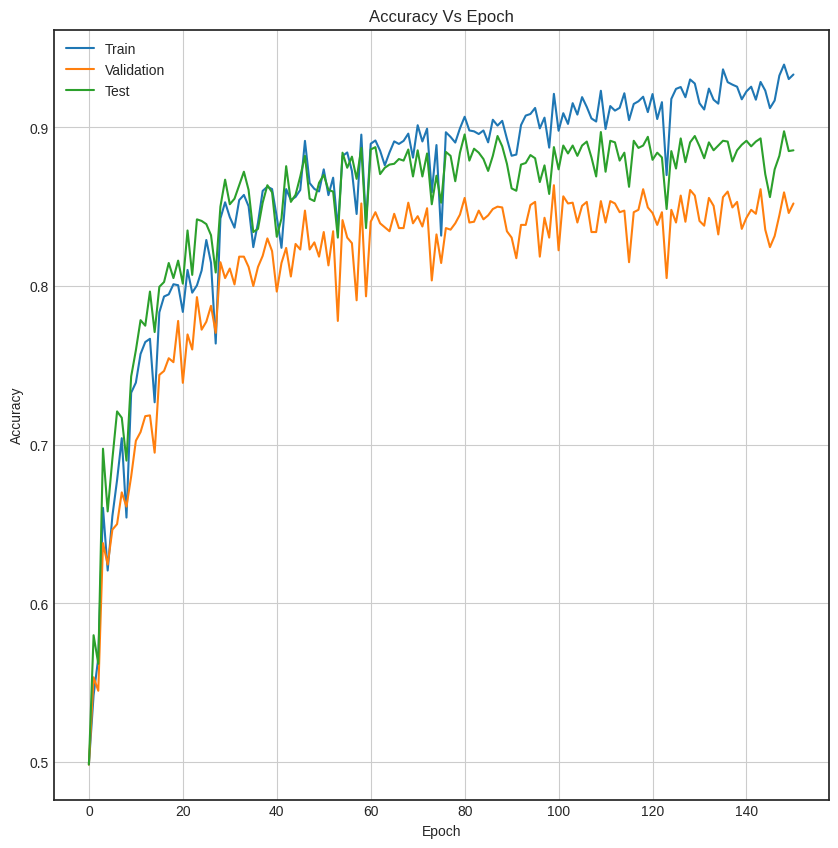

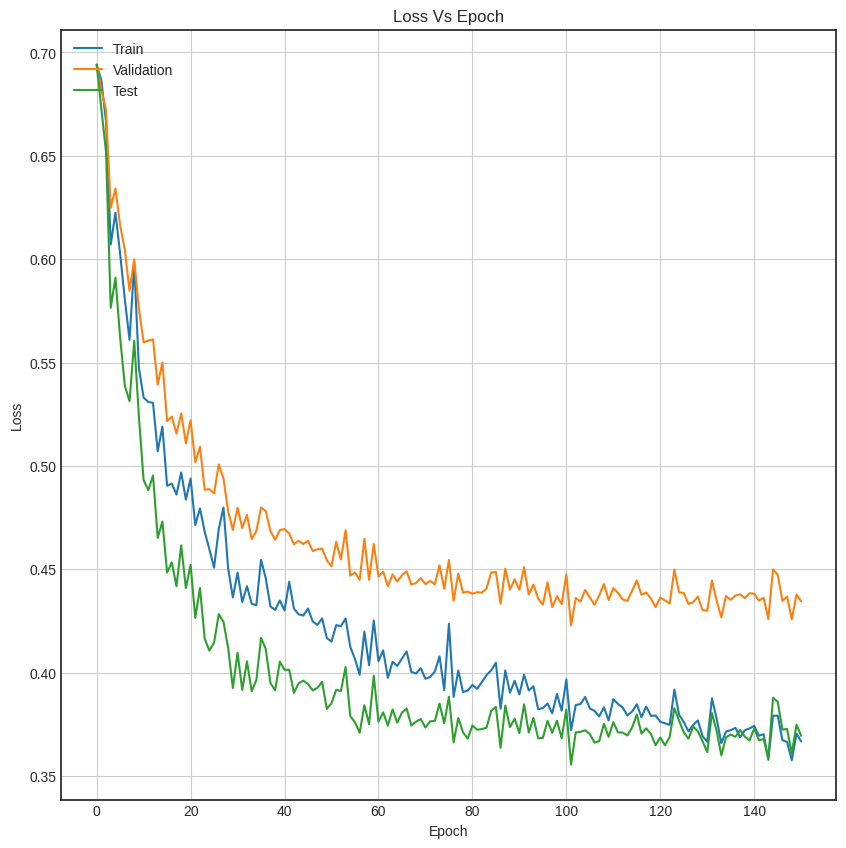

In [ ]:
graphics(AccTest, AccTrain, AccValid, LossTest, LossTrain, LossValid, model_Name, path_img_base)

## Top

In [ ]:
top_models(AccTest,AccTrain,AccValid)

Test Accuracy 0.8974999785423279, epoch:148

Test Accuracy 0.8970000147819519, epoch:109

Test Accuracy 0.8955000042915344, epoch:80

Test Accuracy 0.8945000171661377, epoch:87

Test Accuracy 0.8945000171661377, epoch:129

Test Accuracy 0.8939999938011169, epoch:119

Test Accuracy 0.8930000066757202, epoch:126


Train Accuracy 0.9394999742507935, epoch:148

Train Accuracy 0.9365000128746033, epoch:135

Train Accuracy 0.9332500100135803, epoch:150

Train Accuracy 0.9325624704360962, epoch:147

Train Accuracy 0.9303749799728394, epoch:149

Train Accuracy 0.9301249980926514, epoch:128

Train Accuracy 0.9285625219345093, epoch:143


Validation Accuracy 0.8634999990463257, epoch:99

Validation Accuracy 0.8610000014305115, epoch:118

Validation Accuracy 0.8610000014305115, epoch:143

Validation Accuracy 0.8604999780654907, epoch:128

Validation Accuracy 0.859499990940094, epoch:136

Validation Accuracy 0.859000027179718, epoch:148

Validation Accuracy 0.8569999933242798, epoch:126

